# Test for CB
## Xiaonan Wang
## 24Jun2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata
from mpl_toolkits.mplot3d import Axes3D

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [212]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 0.0, 0.0),
                 (0.4, 0.2, 0.2),
                 (0.6, 0.0, 0.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.1, 0.0, 0.0),
                 (0.2, 0.0, 0.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 1.0, 1.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 1.0, 1.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 0.0, 0.0),
                 (0.8, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}

def plot_3d(adata_ref, obs_key, adata_new=None, obsm_key='X_diffmap', ncols=4,figsize=(6,6), alpha=0.5, azim=250,elev=30, markersize=1,components=[1,2,3], cmap=None):
    nkey = len(obs_key)
    if nkey <=4:
        ncols = nkey
    nrows = int(np.ceil((nkey)/ncols))
    fig = plt.figure(figsize=figsize)
    for nk in range(nkey):
        k = obs_key[nk]
        ax = fig.add_subplot(nrows, ncols, nk+1, projection='3d')
        ax.view_init(azim=azim, elev=elev)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        if adata_new is None:
            adata = adata_ref.copy()
        else:
            adata = adata_new.copy()
            dm_ref = adata_ref.obsm[obsm_key]
            ax.plot(dm_ref[:,components[0]],dm_ref[:,components[1]],dm_ref[:,components[2]], '.', markersize=markersize, c='#d3d3d3', label = 'Ref_data', alpha =alpha)

        dm_new = adata.obsm[obsm_key]
        obs_term = adata.obs[k]
        if obs_term.dtype == 'float32' or obs_term.dtype == int or obs_term.dtype == 'float':
            if cmap is None:
                cmap = LinearSegmentedColormap('my_colormap',cdict,256) 
            #print(np.array(obs_term.values))
            conti_fig = ax.scatter(dm_new[:,components[0]],dm_new[:,components[1]],dm_new[:,components[2]], '.', s=markersize, c=np.array(obs_term.values), cmap=cmap, alpha =alpha)
            fig.colorbar(conti_fig, shrink=0.5)
            
        
        else:
            obs_term = obs_term.astype('category')
            cats = obs_term.cat.categories
            if k+'_colors' in adata.uns_keys():
                color_pal = adata.uns[k+'_colors']
            else:
                color_pal = sc.pl.palettes.default_20[0:len(cats)]
            for i in range(len(cats)):
                #print(cats[i])
                idx = obs_term==cats[i]
                ax.plot(dm_new[idx,components[0]],dm_new[idx,components[1]],dm_new[idx,components[2]], '.', markersize=markersize, c=color_pal[i], label = cats[i], alpha =alpha)

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()

In [3]:
wdir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/'
adata = sc.read(wdir+'MPB1234/write/CBdata_raw.h5ad')
adata.var_names_make_unique()
print('CB shape: '+ str(adata.shape))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CB shape: (535, 65988)


filtered out 21897 genes that are detected in less than 1 cells
Calculate SF for genes:
Filtered matrix shape: (535, 58)
Number of valid means:58
MeanForFit:  5
12137
Length of HVGs: 3342


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


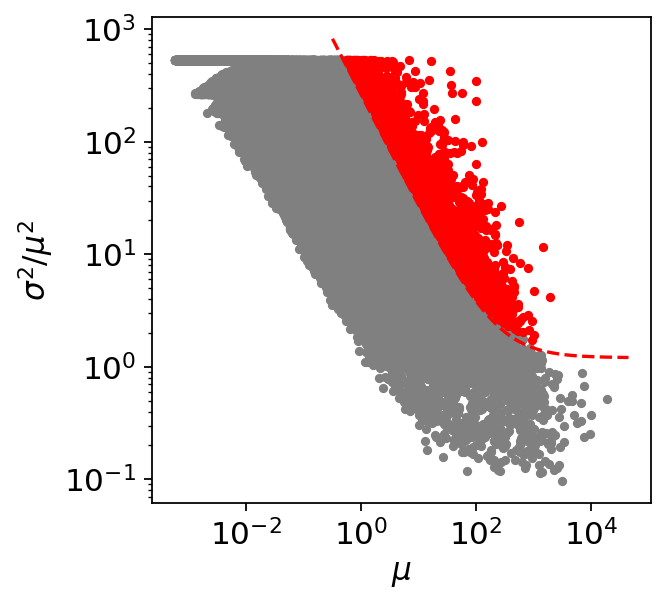

In [4]:
# quick QC
sc.pp.filter_genes(adata, min_cells=1)
adata.var_names_make_unique()
# normalisation
smqpp.normalise_data(adata)
adata.raw = adata
smqpp.tech_var(adata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(adata)
adata.write('./write/CBtest/CB_lognorm.h5ad')

In [6]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)
sc.pp.combat(adata, key='batch')

Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



In [7]:
adata.write('./write/CBtest/CB_lognorm_combat.h5ad')

## Destiny R

In [8]:
adata =sc.read('./write/CBtest/CB_lognorm_combat.h5ad')

In [9]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [11]:
B1X = adata[adata.obs['batch'] == '0', ].X.toarray()
B2X = adata[adata.obs['batch'] == '1', ].X.toarray()

In [12]:
%reload_ext rpy2.ipython

In [15]:
%%R -i B1X -i B2X
suppressMessages(library(destiny))
print("Calculating Diffusion Map B1")
dm_B1 = DiffusionMap(B1X, distance="cosine")
saveRDS(dm_B1, file="dm_CB_B1.rds")
print("Calculating Projection B1")
B2_proj = dm_predict(dm_B1, B2X)
saveRDS(B2_proj, file="CB_B2_proj.rds")
write.table(dm_B1@eigenvectors, "X_DM_CB_B1.csv", quote=F, row.names=T, col.names=T, sep=",")
write.table(as.matrix(B2_proj), "X_DM_CB_B2.csv", quote=F, row.names=T, col.names=T, sep=",")

print("Calculating Diffusion Map all")
dm_CB_test = DiffusionMap(rbind(B1X, B2X), distance="cosine")
saveRDS(dm_CB_test, file="dm_CB_test.rds")
write.table(dm_CB_test@eigenvectors, "X_DM_CB_test.csv", quote=F, row.names=T, col.names=T, sep=",")

[1] "Calculating Diffusion Map B1"
[1] "Calculating Projection B1"
[1] "Calculating Diffusion Map all"


### Combined

In [16]:
DM_co = pd.read_csv('X_DM_CB_test.csv', index_col=0, header=0)

In [17]:
adata.obsm['X_diffmap'] = np.array(DM_co)

In [82]:
np.where(np.in1d(adata.obs_names,'SLX.12561.N702_S502')==True)

(array([364]),)

In [85]:
%%R -o pt_kenny
suppressMessages(library(destiny))
dm_CB_test = readRDS('dm_CB_test.rds')
dpt_kenny_CB = DPT(dm_CB_test, tips=as.integer(365))
saveRDS(dpt_kenny_CB, file="dpt_kenny_CB.rds")
dpt_flat <-  branch_divide(dpt_kenny_CB, integer(0L))
pt_kenny <- destiny:::dpt_for_branch(dpt_flat, 1)

In [86]:
adata.obs['destiny_pt_kenny'] = pt_kenny

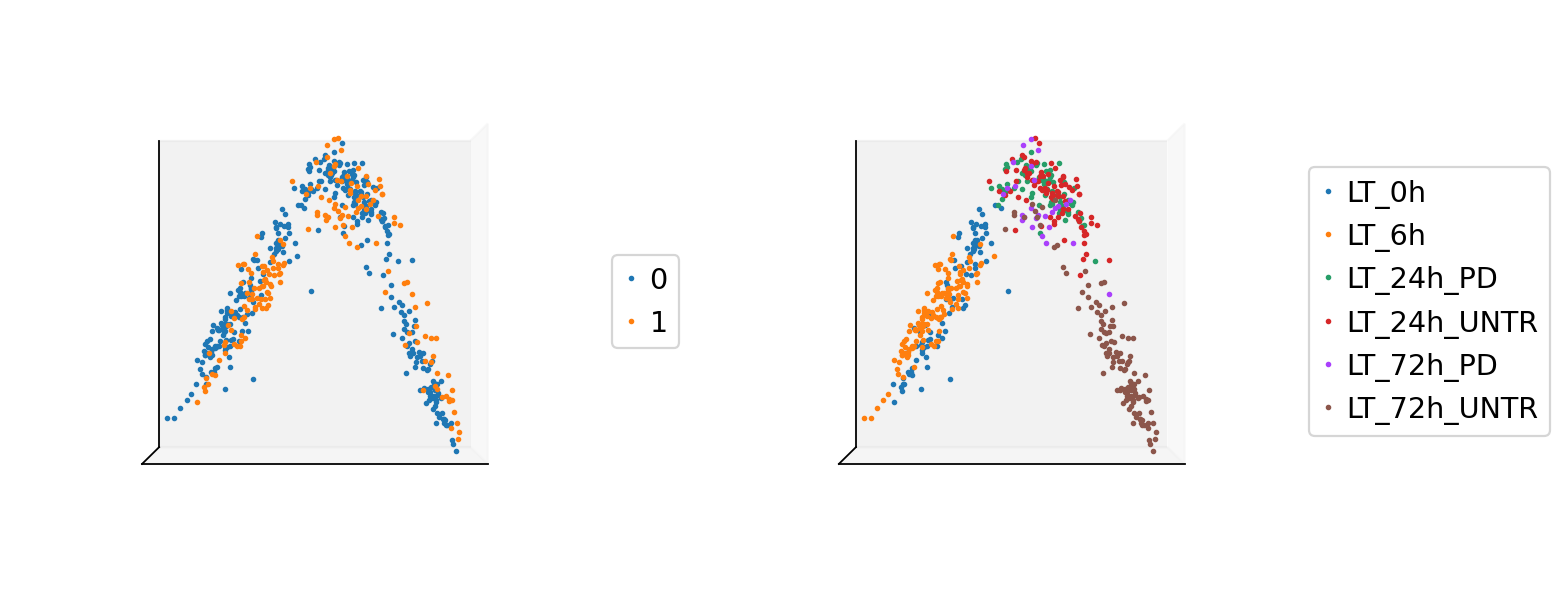

In [128]:
plot_3d(adata, ['batch', 'Details'], figsize=(10,4), azim=90,elev=0, components=[0,1,2], alpha=1, markersize=3)

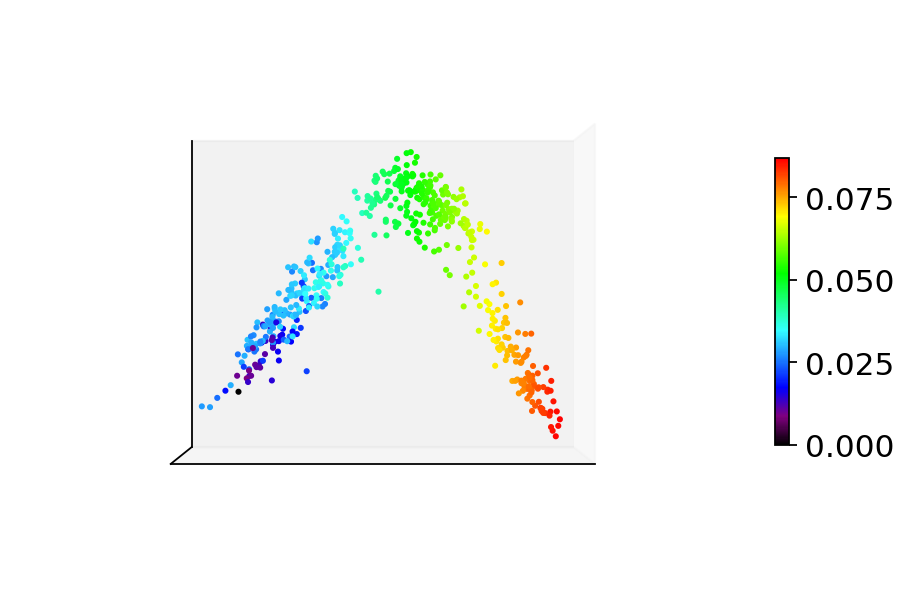

In [129]:
plot_3d(adata, ['destiny_pt_kenny'], figsize=(6,4), azim=90,elev=0, components=[0,1,2], alpha=1, markersize=3)

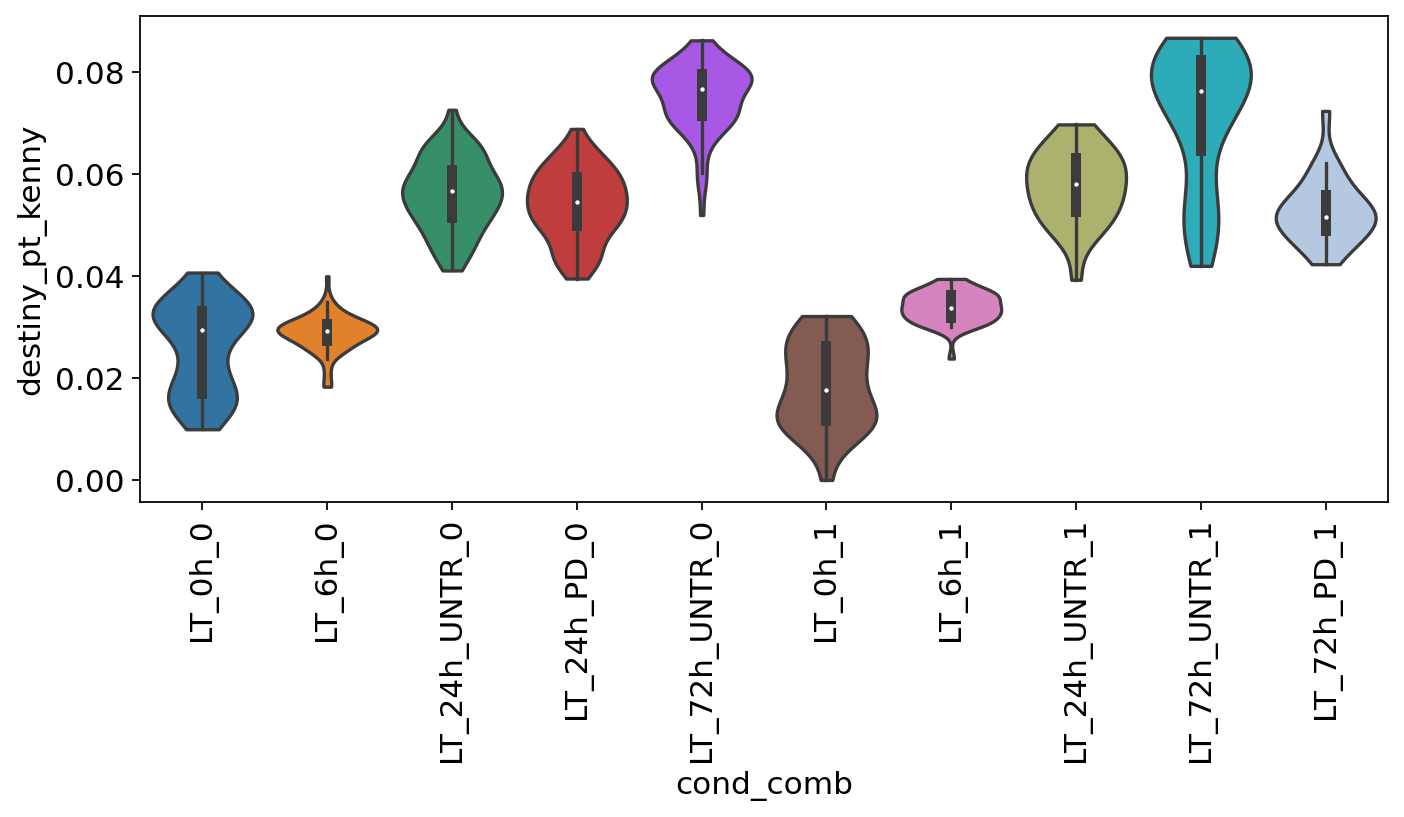

In [132]:
adata.obs['cond_comb'] = adata.obs['Details'].astype(str)+'_'+adata.obs['batch'].astype(str)
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb', y='destiny_pt_kenny',data=adata.obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)

### Projection

In [143]:
B1_co = np.array(pd.read_csv('X_DM_CB_B1.csv', index_col=0, header=0))
B2_co = np.array(pd.read_csv('X_DM_CB_B2.csv', index_col=0, header=0))
adata.obsm['X_diffmap'] = np.vstack([B1_co, B2_co])

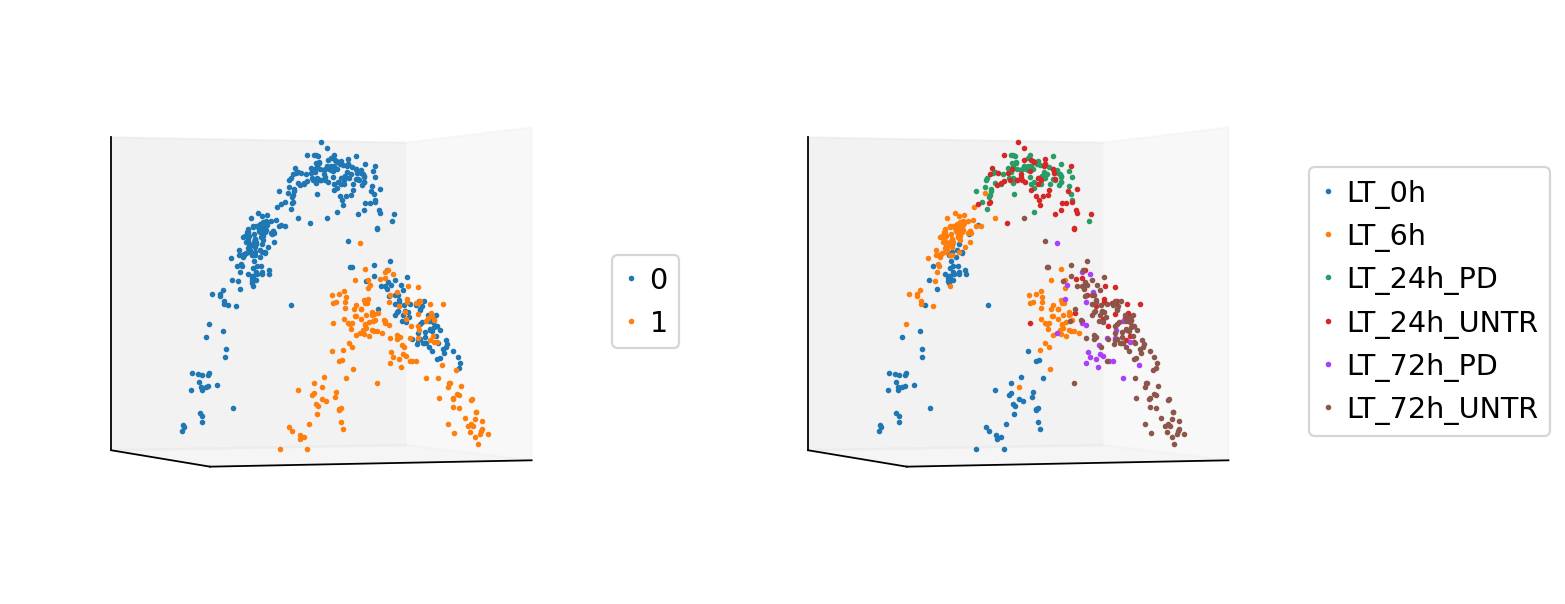

In [153]:
plot_3d(adata, ['batch', 'Details'], figsize=(10,4), azim=70,elev=0, components=[0,1,2], alpha=1, markersize=3)

# Combat scanpy

In [155]:
adata =sc.read('./write/CBtest/CB_lognorm_combat.h5ad')

In [156]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [157]:
# Scale the data for PCA then do other DR
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98946774 0.97594255 0.9631703  0.9344876  0.9255819
     0.8916851  0.8769407  0.8708588  0.8535272  0.83762234 0.82310945
     0.7980202  0.78285134 0.77380663]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [158]:
np.where(np.in1d(adata.obs_names,'SLX.12561.N702_S502')==True)

(array([364]),)

In [160]:
adata.uns['iroot'] = 364

In [161]:
sc.tl.dpt(adata, n_branchings=0)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


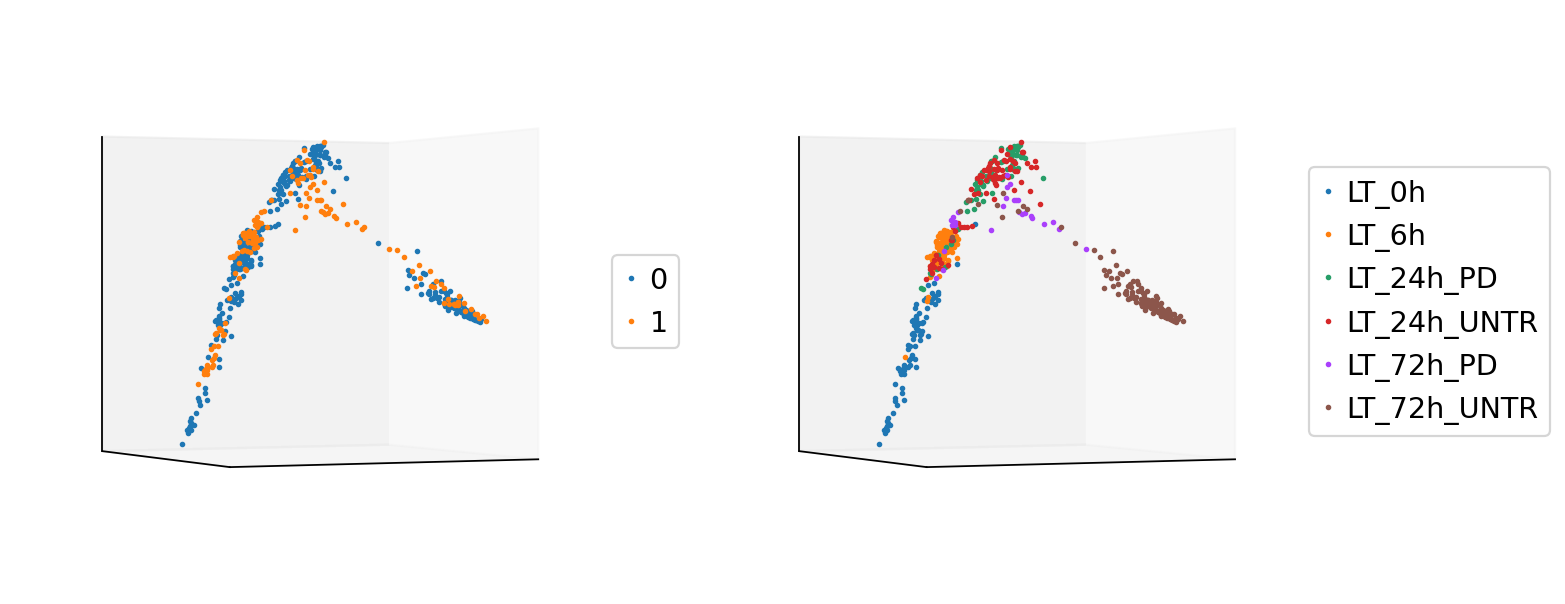

In [208]:
plot_3d(adata, ['batch', 'Details'], figsize=(10,4), azim=65,elev=0, components=[1,2,3], alpha=1, markersize=3)

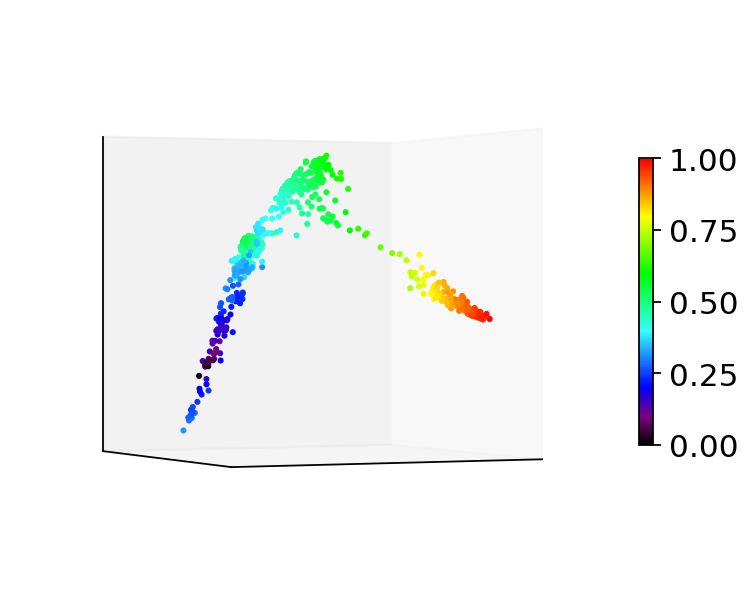

In [214]:
plot_3d(adata, ['dpt_pseudotime'], figsize=(5,4), azim=65,elev=0, components=[1,2,3], alpha=1, markersize=3)

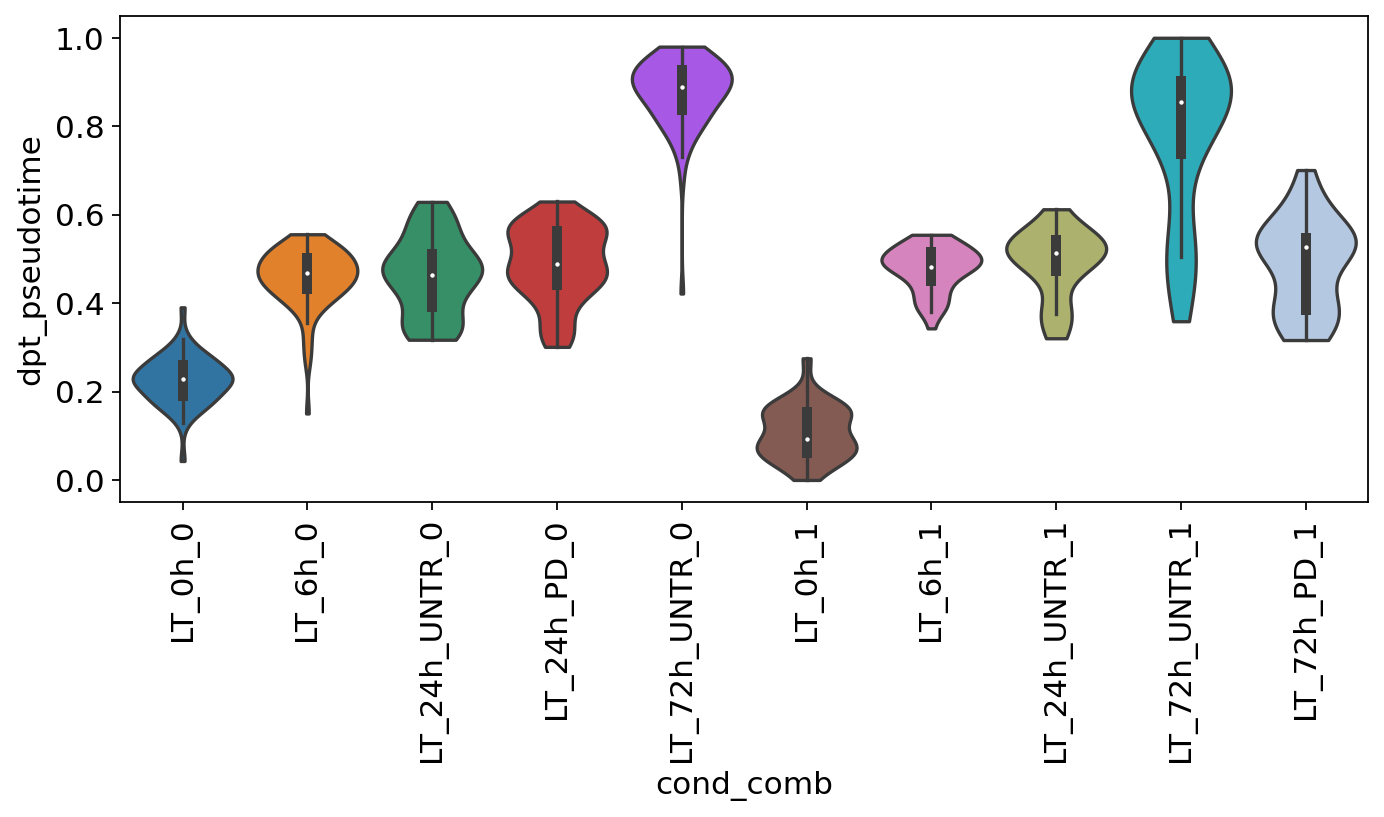

In [216]:
adata.obs['cond_comb'] = adata.obs['Details'].astype(str)+'_'+adata.obs['batch'].astype(str)
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb', y='dpt_pseudotime',data=adata.obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)

# fastMNN

In [217]:
adata = sc.read('./write/CBtest/CB_lognorm.h5ad')

In [218]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [219]:
# Scale the data for PCA
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [222]:
X_pca = adata.obsm['X_pca']
idx0 = adata.obs['batch'] == '0'
print(sum(idx0))
idx1 = adata.obs['batch'] == '1'
print(sum(idx1))
pca0 = pd.DataFrame(X_pca[idx0])
print(pca0.shape)
pca1 = pd.DataFrame(X_pca[idx1])
print(pca1.shape)

360
175
(360, 50)
(175, 50)


In [223]:
%reload_ext rpy2.ipython

In [226]:
%%R -i pca0 -i pca1 -o odf
suppressMessages(library("batchelor"))
odf = reducedMNN(data.matrix(pca0), data.matrix(pca1),
                      BPPARAM=MulticoreParam(detectCores()))
odf = data.frame(odf$corrected)

In [227]:
odf.shape

(535, 50)

In [229]:
CNs = np.concatenate([adata.obs_names[x] for x in [idx0, idx1]])
adata = adata[CNs,:].copy()
adata.obsm['X_pca'] = odf.values

In [230]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9915756  0.97888625 0.9636505  0.9377102  0.92483425
     0.87593246 0.86678374 0.8534594  0.8423739  0.79898614 0.754609
     0.7470742  0.73999965 0.7233108 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [231]:
np.where(np.in1d(adata.obs_names,'SLX.12561.N702_S502')==True)

(array([364]),)

In [232]:
adata.uns['iroot'] = 364

In [233]:
sc.tl.dpt(adata, n_branchings=0)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


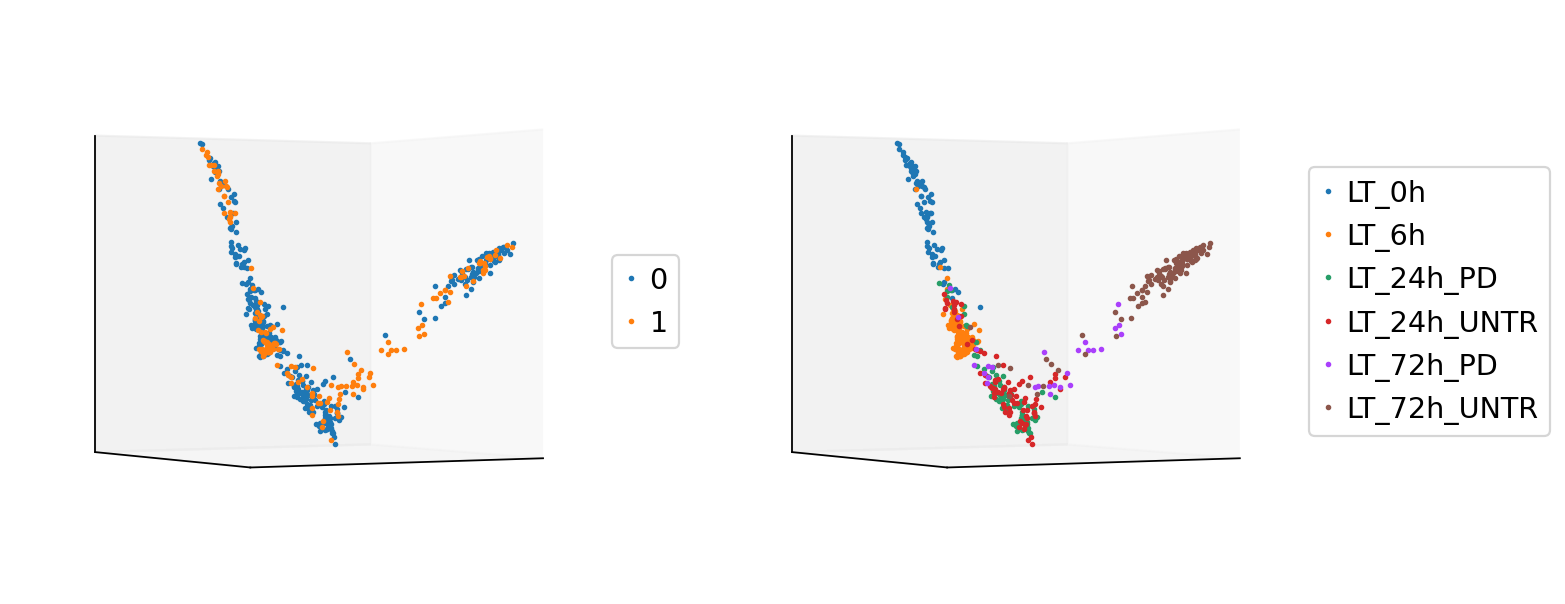

In [244]:
plot_3d(adata, ['batch', 'Details'], figsize=(10,4), azim=300,elev=360, components=[1,2,3], alpha=1, markersize=3)

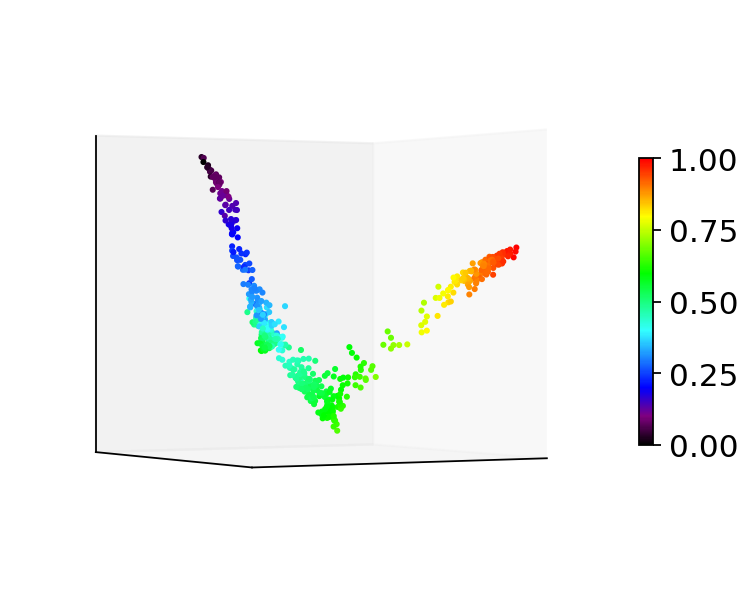

In [245]:
plot_3d(adata, ['dpt_pseudotime'], figsize=(5,4), azim=300,elev=360, components=[1,2,3], alpha=1, markersize=3)

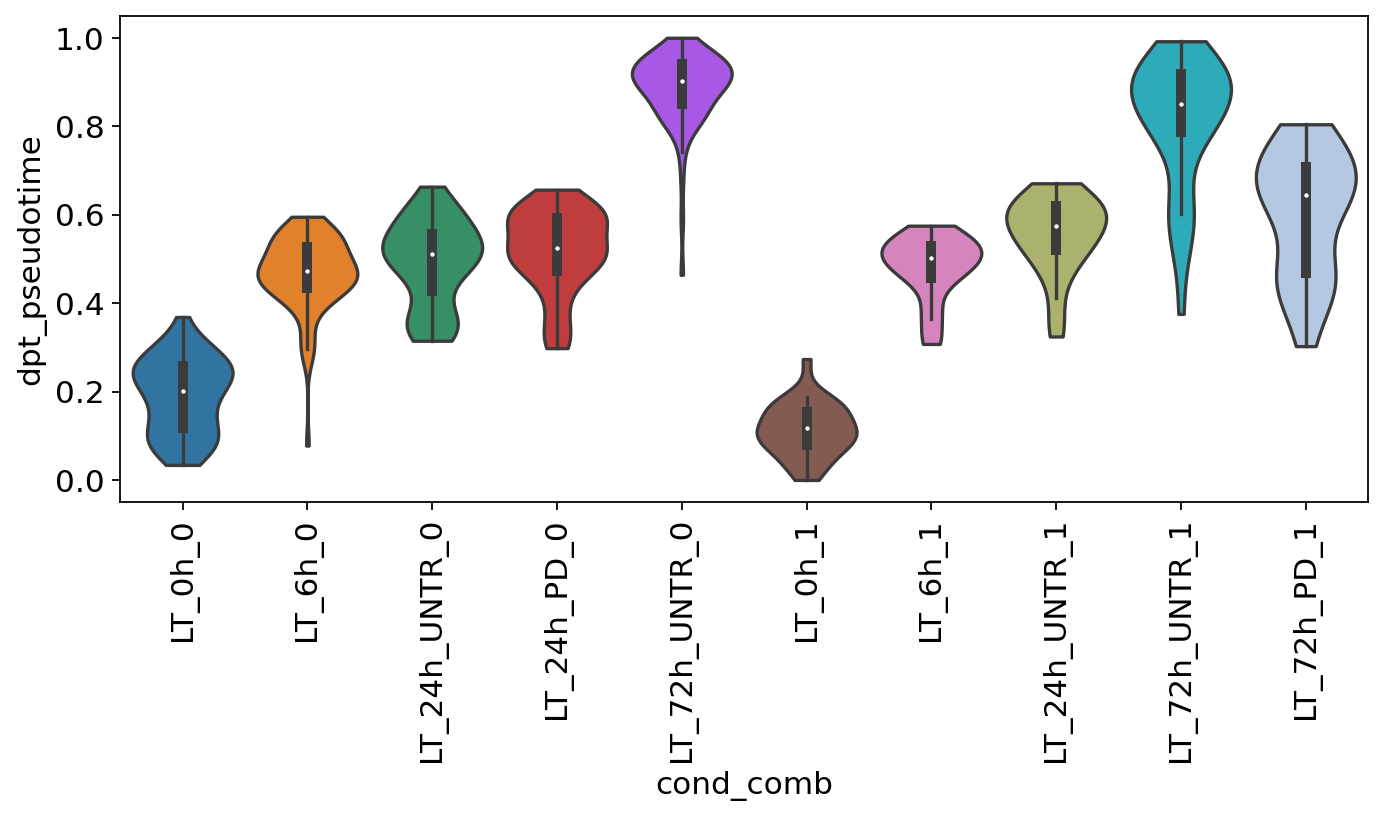

In [246]:
adata.obs['cond_comb'] = adata.obs['Details'].astype(str)+'_'+adata.obs['batch'].astype(str)
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb', y='dpt_pseudotime',data=adata.obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)